In [1]:
!pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.7 MB/s eta 0:00:00


In [2]:
import math
import numpy as np
import random
import ot

import matplotlib.pyplot as plt
import ot.plot

Text(0.5, 1.0, 'Source and target distributions')

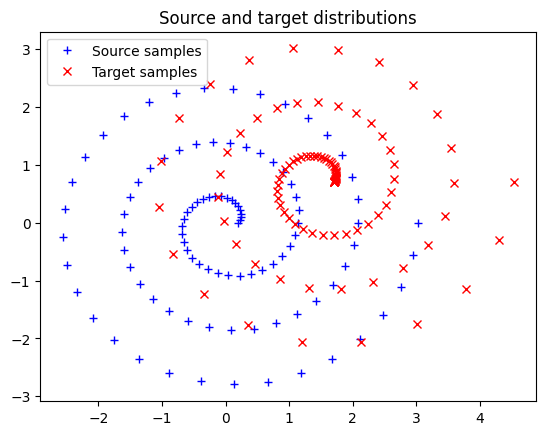

In [3]:
def spiral(t, a=0.2, b=0.15):
    # 간단한 나선 (r(t)=a + b t)
    r = a + b*t
    return np.stack([r*np.cos(t), r*np.sin(t)], axis=1)

n = 100
tX = np.linspace(0, 6*np.pi, n)             # 균일 시간
xs  = spiral(tX) #+ 0.05*np.random.randn(n,2)

# time-warping: 느리다가 빠르게 (모노톤 증가이지만 비균일)
# tau = np.linspace(0, 1, n)
# tw  = tau**1.8
# tY  = (tw*(tX[-1]-tX[0]) + tX[0])
# R   = np.array([[np.cos(0.5), -np.sin(0.5)],[np.sin(0.5), np.cos(0.5)]])
# shift= np.array([1.5, 0.7])
# xt  = (spiral(tY) @ R.T) + shift + 0.05*np.random.randn(n,2)

tau = np.linspace(0, 1, n)
tw  = tau**1.8
tY  = (tw*(tX[-1]-tX[0]) + tX[0])
shift= np.array([1.5, 0.7])
xt  = (spiral(tY)) + shift #+ 0.05*np.random.randn(n,2)

# shift= np.array([1.5, 0.7])
# xt  = xs + shift #+ 0.05*np.random.randn(n,2)


plt.figure(1)
plt.plot(xs[:, 0], xs[:, 1], "+b", label="Source samples")
plt.plot(xt[:, 0], xt[:, 1], "xr", label="Target samples")
plt.legend(loc=0)
plt.title("Source and target distributions")

In [4]:
def index_kernel_matrix(L, h):
    # L x L, [i,j] = exp(-(i-j)^2 / (2h^2))
    idx = np.arange(L)
    D = (idx[:, None] - idx[None, :])**2
    Kh = np.exp(- D / (2.0 * (h**2)))
    np.fill_diagonal(Kh, 0.0)      # 구조항에서 자기쌍 제외하고 싶으면 0 권장
    Kh = 0.5 * (Kh + Kh.T)         # 수치적 대칭화
    return Kh

In [5]:
M = ot.dist(xs,xt, metric='sqeuclidean')
C1 = ot.dist(xs,xs, metric='euclidean')
C2 = ot.dist(xt,xt, metric='euclidean')

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

hX = max(1.0, len(xs)/20)  # 대역폭 초기값 예시(길이의 ~5%); 상황에 맞게 조정
hY = max(1.0, len(xt)/20)


KhX = index_kernel_matrix(len(xs), hX)
KhY = index_kernel_matrix(len(xt), hY)
eps = 1e-12
C1p = KhX * C1
C2p = KhY * C2
C1p *= (C1.mean() + eps) / (C1p.mean() + eps)
C2p *= (C2.mean() + eps) / (C2p.mean() + eps)

alpha = 1
T_kernel = ot.gromov.fused_gromov_wasserstein(M, C1p, C2p, a, b, alpha=alpha, loss_fun='square_loss')

# 비교: 커널 미사용(표준 FGW)
T_plain = ot.gromov.fused_gromov_wasserstein(M, C1, C2, a, b, alpha=alpha, loss_fun='square_loss')

# 비교: pure feature OT (alpha=0, EMD)
T_feat = ot.solve(M, a, b).plan

In [6]:
def plot_transport_heatmap(T, title="Transport plan T (rows: X_i, cols: Y_j)"):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(T, aspect='auto')  # 행: X_i, 열: Y_j
    ax.set_xlabel('target index j')
    ax.set_ylabel('source index i')
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('mass T[i,j]')
    plt.tight_layout()
    plt.show()

def barycentric_projection(T, Y, a):
    # \hat{Y}_i = (1/a_i) * sum_j T[i,j] * Y_j
    denom = a[:, None]  # (n,1)
    return (T @ Y) / denom

def plot_barycentric(xs, xt, T, a, k=3, jitter=0.2, eps=1e-12):
    n, m = T.shape
    # barycentric
    y_hat = (T @ xt) / a[:, None]

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(xs[:,0]-jitter, xs[:,1], s=25, color='blue', label='X (source)')
    ax.scatter(xt[:,0]+jitter, xt[:,1], s=25, marker='x', color='red', label='Y (target)')

    # # barycentric arrows (항상 1개)
    # for i in range(n):
    #     ax.arrow(xs[i,0]-jitter, xs[i,1],
    #              y_hat[i,0] - (xs[i,0]-jitter),
    #              y_hat[i,1] -  xs[i,1],
    #              head_width=0.0, length_includes_head=True, alpha=0.6)

    # top-k edges but only if T[i,j] > eps
    for i in range(n):
        js = np.argsort(T[i])[::-1]
        count = 0
        for j in js:
            if T[i,j] <= eps:  # 0이면 그리지 않음
                continue
            ax.plot([xs[i,0]-jitter, xt[j,0]+jitter],
                    [xs[i,1],         xt[j,1]],
                    #linewidth=1.0 + 4.0*T[i,j]/(T.max()+eps),
                    color='black',
                    alpha=0.2)
            count += 1
            if count >= k:
                break

    # ax.set_title(f'Transport flows (top ≤{k} per source, threshold {eps})')
    ax.set_title(f'Transport flows')
    ax.legend()
    ax.set_aspect('equal', adjustable='datalim')
    plt.tight_layout()
    plt.show()

def plot_barycentric_subset(xs, xt, T, a, idx_src, idx_tgt=None, **kwargs):
    if idx_tgt is None:
        idx_tgt = idx_src
    a_sub = a[idx_src] / a[idx_src].sum()
    plot_barycentric(xs[idx_src,:], xt[idx_tgt,:], T[np.ix_(idx_src, idx_tgt)], a_sub, **kwargs)

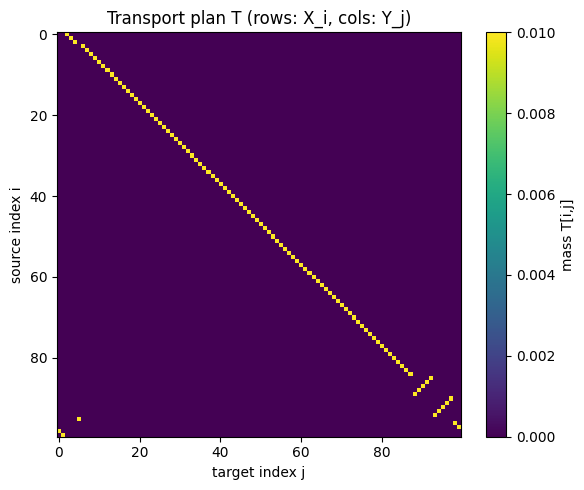

In [7]:
plot_transport_heatmap(T_kernel)

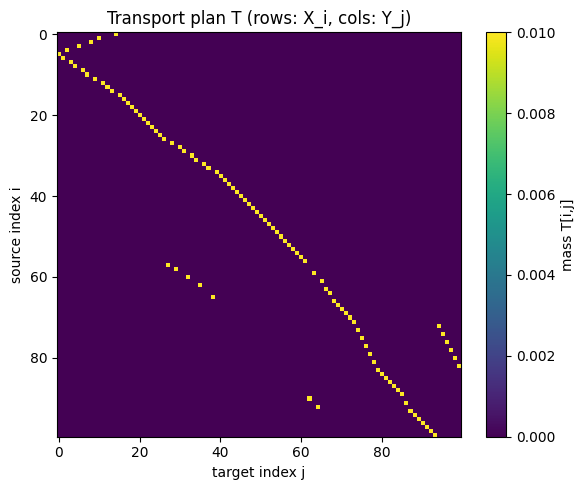

In [8]:
plot_transport_heatmap(T_plain)

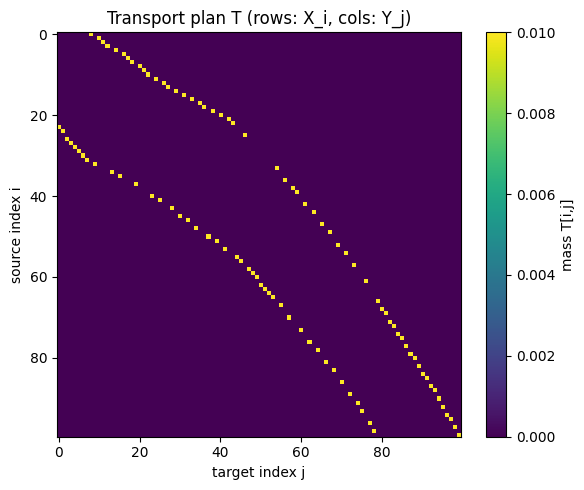

In [9]:
plot_transport_heatmap(T_feat)

In [10]:
# def top1_matching(T):
#     return np.argmax(T, axis=1)

# def monotonicity_score(T):
#     j = top1_matching(T)
#     i = np.arange(len(j))
#     # 스피어만 상관 (단조성)
#     from scipy.stats import spearmanr
#     return spearmanr(i, j).correlation

# print("Spearman (kernel FGW):", monotonicity_score(T_kernel))
# print("Spearman (plain  FGW):", monotonicity_score(T_plain))
# print("Spearman (feature OT):", monotonicity_score(T_feat))

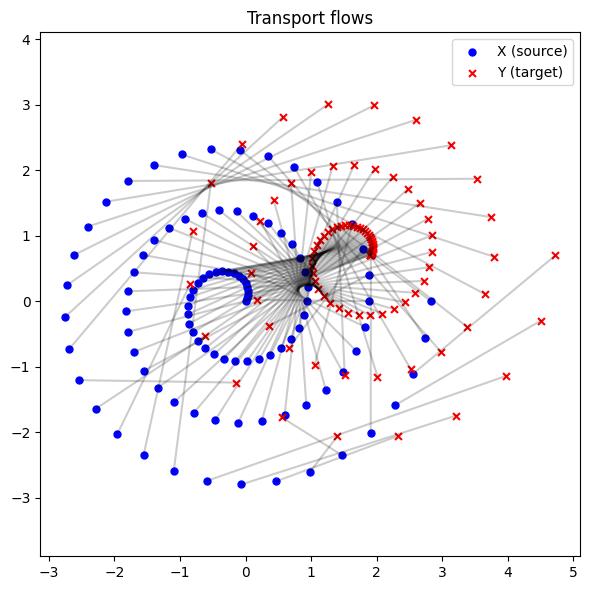

In [11]:
plot_barycentric(xs, xt, T_kernel,a, k=1)

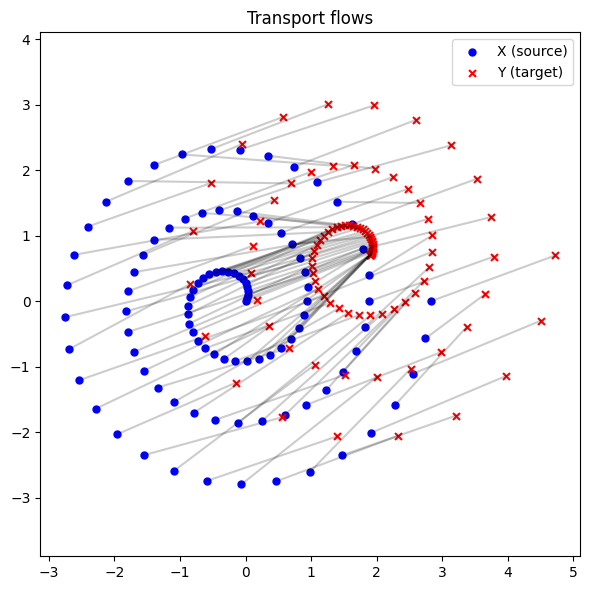

In [12]:
plot_barycentric(xs, xt, T_feat,a, k=1)

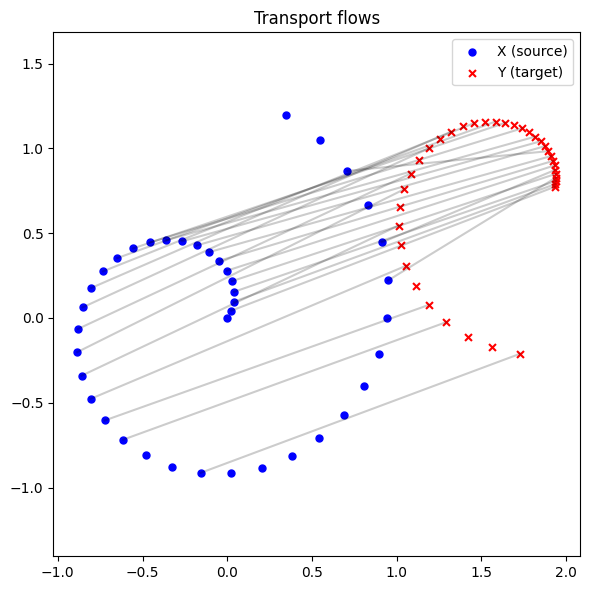

In [13]:
plot_barycentric_subset(xs, xt, T_feat, a, np.arange(0,40),np.arange(10,47), k=1)

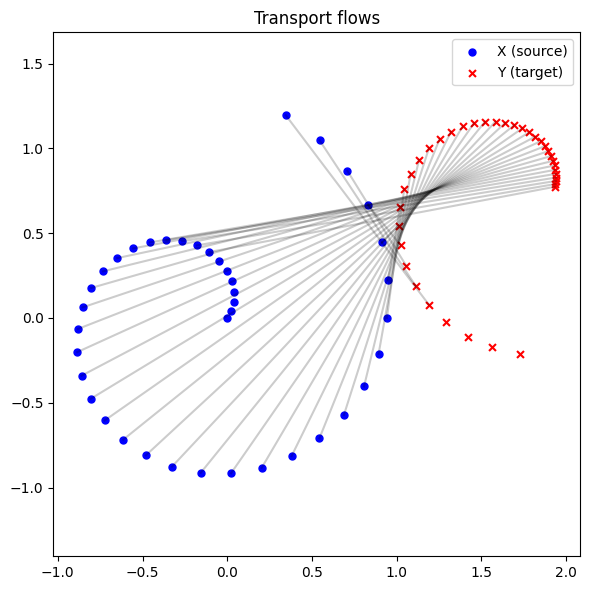

In [14]:
plot_barycentric_subset(xs, xt, T_kernel, a, np.arange(0,40),np.arange(10,47), k=1)